In [1]:
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as nng
import numpy as np


import util
from Dimploma.EnvironmentTree import EnvMinimalTree, EnvMinimalTreeTwoStep
from Dimploma.ppo_parallel_custom import Agent, test_random
from Dimploma.utils.graph_provider import GraphProvider

In [2]:
%load_ext autoreload
%autoreload 2

In [40]:
class GCN(torch.nn.Module):
    def __init__(self, out_size, num_node_features):
        super().__init__()
        self.out_size = out_size
        self.conv1 = nng.GATConv(num_node_features, 16)
        self.conv2 = nng.GATConv(16 + num_node_features, 16)
        self.conv3 = nng.GATConv(16 + num_node_features, 16)
        # self.conv4 = nng.GATConv(16 + num_node_features, 16)
        # self.conv3 = GCNConv(16, 16)
        # self.conv4 = GCNConv(16, 16)

        # self.conv_p1 = nng.GATConv(16 + num_node_features, 16)
        self.conv_p2 = nng.GATConv(16 + num_node_features, 1)
        # self.fc_p1 = nn.Linear(16, 16)
        # self.fc_p2 = nn.Linear(16, graph_t.num_nodes)
        # self.fc_p2 = nn.Linear(16, 1)

        self.fc_v1 = nn.Linear(16, 16)
        self.fc_v2 = nn.Linear(16, 1)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_normal_(module.weight)
            torch.nn.init.zeros_(module.bias)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr[:, :2] # take only the normalized distances with edge_attr[:, 0]
        # print(data.num_node_features)
        # print(f'x start: {x.shape}')
        # print(f'Edge index start: {edge_index.shape}')
        # print(f'Edge index start: {edge_weight}')

        xa = F.relu(self.conv1(x, edge_index, edge_weight))
        # print(f'Edge index after conv1: {edge_weight}')
        # print(f'x conv1: {x.shape}')
        # print(f'xa conv1: {xa.shape}')
        # print(f'Edge index conv1: {edge_index.shape}')
        # x = F.dropout(x, training=self.training)
        xa = F.relu(self.conv2(torch.cat((xa, x), dim=1), edge_index, edge_weight))
        # print(f'Edge index after conv2: {edge_weight}')
        # print(f'x conv2: {x.shape}')
        # print(f'xa conv2: {xa.shape}')
        # print(f'Edge index conv2: {edge_index.shape}')

        # x = F.sigmoid(self.conv3(x, edge_index, edge_weight))
        xa = F.relu(self.conv3(torch.cat((xa, x), dim=1), edge_index, edge_weight))
        # # print(f'Edge index after conv3: {edge_weight}')
        # # print(f'x conv3: {x.shape}')
        # xa = F.relu(self.conv4(torch.cat((xa, x), dim=1), edge_index, edge_weight))
        # x = F.sigmoid(self.conv4(x, edge_index, edge_weight))
        # print(f'Edge index after conv4: {edge_weight}')
        
        # px = F.relu(self.conv_p1(torch.cat((xa, x), dim=1), edge_index, edge_weight))
        # print(f'x convp1: {x.shape}')
        px = F.relu(self.conv_p2(torch.cat((xa, x), dim=1), edge_index, edge_weight))
        # px = F.relu(self.conv_p2(torch.cat((px, x), dim=1), edge_index, edge_weight))
        # print(f'x convp2: {x.shape}')

        px = px.view(-1, min(self.out_size, px.shape[0]))
        # X = X.view(-1, self.node_count)
        
        xa = xa.unsqueeze(0)
        xa = xa.view(-1, min(self.out_size, xa.shape[1]), self.conv1.out_channels)
        v = xa.mean(dim=1)
        v = F.relu(self.fc_v1(v))
        # print(f'v fcv1: {v.shape}')
        vx = self.fc_v2(v)

        # print(f'x result: {X.shape}')
        # print(f'v result: {V.shape}')
        # print(f'Edge index end: {edge_weight}')
        return px, vx

device:  cpu
Fixing graph


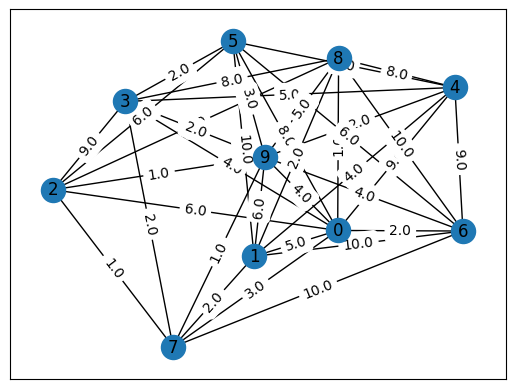

Name: n10_e36_eps03_lr02
tensor([[0, 0, 0, 2, 0, 5, 7, 0, 8, 4, 4, 1, 4, 4, 0, 7, 6, 2, 3, 8, 6, 1, 3, 9,
         2, 5, 7, 9, 1, 8, 7, 1, 0, 7, 4, 9],
        [7, 4, 2, 5, 8, 9, 1, 3, 6, 1, 9, 0, 6, 3, 6, 2, 9, 8, 5, 1, 5, 6, 8, 0,
         3, 4, 9, 3, 5, 9, 6, 9, 5, 3, 8, 2]]) tensor([[ 3.,  0.],
        [ 9.,  0.],
        [ 6.,  0.],
        [ 6.,  0.],
        [ 1.,  0.],
        [ 3.,  0.],
        [ 2.,  0.],
        [ 4.,  0.],
        [10.,  0.],
        [ 4.,  0.],
        [ 2.,  0.],
        [ 5.,  0.],
        [ 9.,  0.],
        [ 5.,  0.],
        [ 2.,  0.],
        [ 1.,  0.],
        [ 4.,  0.],
        [ 8.,  0.],
        [ 2.,  0.],
        [ 2.,  0.],
        [ 6.,  0.],
        [10.,  0.],
        [ 8.,  0.],
        [ 4.,  0.],
        [ 9.,  0.],
        [ 1.,  0.],
        [ 1.,  0.],
        [ 2.,  0.],
        [10.,  0.],
        [ 5.,  0.],
        [10.,  0.],
        [ 6.,  0.],
        [ 8.,  0.],
        [ 2.,  0.],
        [ 8.,  0.],
        [ 1.,  0.]])

In [86]:
node_amount = 10
edge_amount = int(45*0.8)
iteration_amount = 1500
epoch_amount = 10
batch_size = 64
node_features = 2  # (index, {0,1} selected or not)
steps_amount = int((node_amount - 1)*2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device: ', device)


gamma=0.99
epsilon=0.3
coef_value=0.5
coef_entropy=0.001
gae_lambda=0.95
lr=0.00025


fixed_graph = True
# load_graph = 'results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/graph.pt'
load_graph = ''
# load_from = 'results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/models/iter_499_last.pt'
# load_from = 'results/min_tree_ppo/node/250103_18#n10_e45_not_fixed/models/iter_999_last.pt'
load_from = ''
node_env = True
graph = None

if load_graph != '':
    print('Loading graph')
    graph = torch.load(load_graph)
    util.show_data(graph)
elif fixed_graph:
    print('Fixing graph')
    graph = util.generate_random_graph_add_method(node_amount, edge_amount, device=device)
    util.show_data(graph)

graph_provider = GraphProvider(fixed_graph=graph, device=device, nodes=node_amount, edges=edge_amount)


name = f'n{node_amount}_e{edge_amount}_eps03_lr02'

training_desc = f'''
Trying to improve the 3-1gat
trying out training with:
3-1GAT layers
fixed graph
1500 iterations

Parameters:
Gamma: {gamma}
Epsilon: {epsilon}
Coef_value: {coef_value}
Coef_Entropy: {coef_entropy}
Gae_lambda: {gae_lambda}
Learning rate: {lr}
'''

path = 'results/min_tree_ppo/node/'
last_path = f'models/iter_{iteration_amount - 1}_last.pt'
print("Name:", name)
if fixed_graph:
    print(graph.edge_index, graph.edge_attr, graph.x)

In [87]:
last_name = "fuckup"

In [88]:
start_date = datetime.now()

try:
    # noinspection PyUnresolvedReferences
    if last_name == name:
        raise Exception("You should change the name :D")
except NameError:
    raise Exception("You should init last name :D")

if training_desc == '':
    raise Exception("You should write a nice description :D")

last_name = name

net = GCN(node_amount if node_env else edge_amount, node_features)

print(f'Agent {name}')

agent = Agent(model=net, gamma=gamma, epsilon=epsilon, coef_value=coef_value, coef_entropy=coef_entropy, gae_lambda=gae_lambda, lr=lr, device=device, path=path, name=name, override=True)
# agent = Agent(model=net, device=device, path=path, name=name, override=True)

if load_from != '':
    agent.load_model(load_from)

agent.training_description(training_desc)
training_desc = ''
# agent.train([device, None, node_amount, edge_amount], EnvMinimalTreeTwoStep if node_env else EnvMinimalTree, node_amount, count_of_processes=1, count_of_envs=1, batch_size=32, count_of_iterations=iteration_amount)
agent.train([graph_provider], EnvMinimalTreeTwoStep if node_env else EnvMinimalTree, node_amount, count_of_iterations=iteration_amount, count_of_epochs=epoch_amount, batch_size=batch_size, count_of_steps=steps_amount)


end_date = datetime.now()
torch.save(graph, agent.path + '/graph.pt')
s = (end_date - start_date).seconds
hours, remainder = divmod(s, 3600)
minutes, seconds = divmod(remainder, 60)
print(f'Time training {int(hours):02}:{int(minutes):02}:{int(seconds):02}')

Agent n10_e36_eps03_lr02
Training is starting
Iteration 0 starting
Iteration 0	episode 32	avg score -1.27902	best score 0.21429	best avg score -1.27902
Iteration 1 starting
Iteration 1	episode 64	avg score -1.15179	best score 0.21429	best avg score -1.15179
Iteration 2 starting
Iteration 2	episode 96	avg score -1.15923	best score 0.21429	best avg score -1.15179
Iteration 3 starting
Iteration 3	episode 128	avg score -1.19000	best score 0.21429	best avg score -1.15179
Iteration 4 starting
Iteration 4	episode 160	avg score -1.31571	best score 0.21429	best avg score -1.15179
Iteration 5 starting
Iteration 5	episode 192	avg score -1.32071	best score 0.21429	best avg score -1.15179
Iteration 6 starting
Iteration 6	episode 224	avg score -1.30286	best score 0.21429	best avg score -1.15179
Iteration 7 starting
Iteration 7	episode 256	avg score -1.25214	best score 0.21429	best avg score -1.15179
Iteration 8 starting
Iteration 8	episode 288	avg score -1.25214	best score 0.21429	best avg score -1.

In [36]:
agent.path

'results/min_tree_ppo/node/250103_18#n10_e45_not_fixed/'

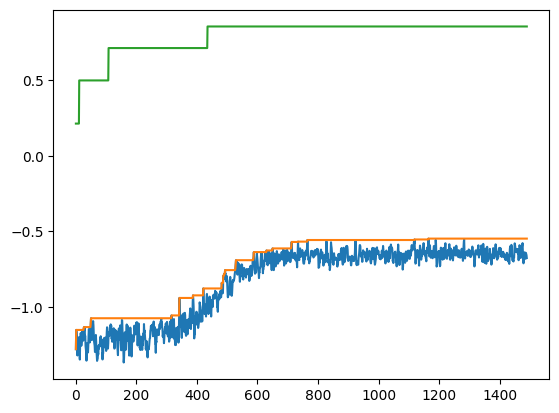

In [89]:
# graph from training
util.plot_training(agent.path)
# util.plot_training('results/min_tree_ppo/node/241217_15#n10_e45_cat_part2/')
# util.plot_training('results/min_tree_ppo/node/241217_14#n10_e45_cat/')
# util.plot_training('results/min_tree_ppo/node/241207_14#n10_e45/')

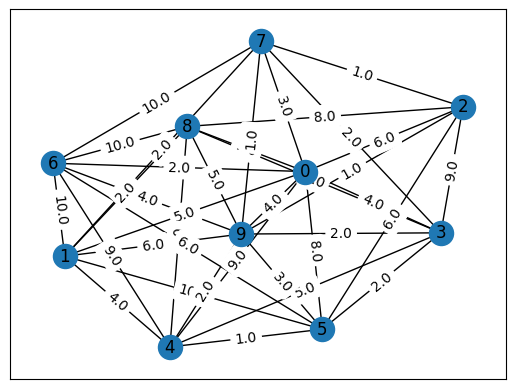

In [90]:
# loaded_graph = torch.load('results/min_tree_ppo/node/241207_14#n10_e45/graph.pt')
loaded_graph = torch.load(agent.path + '/graph.pt')
util.show_data(loaded_graph)

In [91]:
test_amount = 100

In [92]:
# graph_test = util.generate_random_graph(node_amount, edge_amount)
graph_test = graph

In [93]:
graph_provider.set_fixed_graph(loaded_graph)

In [94]:

test_env = EnvMinimalTreeTwoStep(graph_provider)

net_test = GCN(node_amount if node_env else edge_amount, node_features)
agent_test = Agent(model=net_test, device=device, name=name + "_test", override=True, test=True)

agent_test.load_model(f"{agent.path}{last_path}")
# agent_test.load_model(f"results/min_tree_ppo/node/241207_14#n10_e45/models/iter_642.pt")



Loading model from results/min_tree_ppo/node/250129_23#n10_e36_eps03_lr02/models/iter_1499_last.pt


In [96]:
# Testing
objs_test = np.zeros(test_amount, dtype=np.float32)
rews_test = np.zeros(test_amount, dtype=np.float32)
actions_test = np.zeros((test_amount, node_amount * 2), dtype=np.int16)

objs_test_r = np.zeros(test_amount, dtype=np.float32)
rews_test_r = np.zeros(test_amount, dtype=np.float32)
actions_test_r = np.zeros((test_amount, node_amount * 2), dtype=np.int16)

for i in range(test_amount):
    obj, sel, rew, acts = agent_test.test(test_env)
    objs_test[i] = obj
    rews_test[i] = rew[-1]
    actions_test[i, :len(acts)] = acts
    
    obj_r, sel_r, rew_r, acts_r  = test_random(test_env)
    objs_test_r[i] = obj_r
    rews_test_r[i] = rew_r[-1]
    actions_test_r[i, :len(acts_r)] = acts_r
    # print(sel)

print("Objs")
print(f'Mean: {objs_test.mean():.2f}')
print(f'Min: {objs_test.min()}')
print(f'Max: {objs_test.max()}')
print("Random")
print(f'Mean: {objs_test_r.mean():.2f}')
print(f'Min: {objs_test_r.min()}')
print(f'Max: {objs_test_r.max()}')

Objs
Mean: 37.35
Min: 27.0
Max: 52.0
Random
Mean: 45.20
Min: 20.0
Max: 61.0


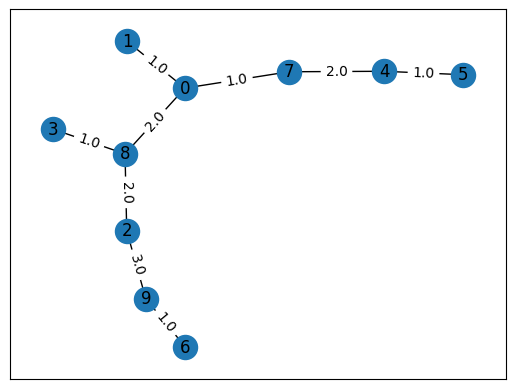

In [73]:
util.show_data(test_env.min_tree)

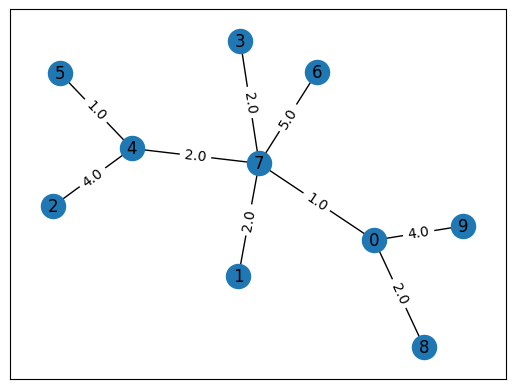

(tensor([0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3571428571428572],
 [7, 4, 4, 2, 7, 0, 7, 1, 0, 9, 7, 6, 7, 3, 4, 5, 0, 8])

In [85]:
_ ,a, b, c = agent_test.test(test_env)

test_env.show_selected_tree()

# mask = torch.argwhere(graph_test.edge_attr[:, 1] == 1)[:, 0]
# sel_graph = Data(x=graph_test.x, edge_index=graph_test.edge_index[:, mask], edge_weight=graph_test.edge_weight[mask])
# sel_graph_g = util.my_to_networkx(sel_graph)
# util.show_data(sel_graph)
a,b,c

In [79]:
util.get_node_sums(loaded_graph)

tensor([[ 5.,  7.,  4.,  0.,  3.,  8.,  2.,  1.,  9.,  6.],
        [17., 24., 26., 30., 32., 32., 38., 42., 42., 57.]])

In [79]:
util.generate_random_graph_add_method(10, 15).x.shape

torch.Size([10, 2])

In [80]:
util.generate_random_full_graph(10).x.shape

torch.Size([10, 2])